In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
# Chemin vers le fichier Excel
file_path = "employes_dataset.xlsx"  # adapte le chemin si nécessaire

# Charger le dataset
df = pd.read_excel(file_path)

# Supprimer les lignes avec des valeurs manquantes, sauf dans "Télétravail (%)"
colonnes_a_verifier = [col for col in df.columns if col != "Télétravail (%)"]
df_cleaned = df.dropna(subset=colonnes_a_verifier)

# Afficher les premières lignes du dataset nettoyé
print("Aperçu du dataset nettoyé :")
print(df_cleaned.head())


In [19]:

# Charger le dataset
file_path = "employes_dataset.xlsx"
df = pd.read_excel(file_path)

# Supprimer les lignes avec des valeurs manquantes sauf dans "Télétravail (%)"
df = df.dropna(subset=[col for col in df.columns if col != "Télétravail (%)"])

# Séparer données connues/inconnues pour la cible
df_known = df[df["Télétravail (%)"].notna()]
df_unknown = df[df["Télétravail (%)"].isna()]

# Supprimer la colonne "ID" si présente (non pertinente pour l'apprentissage)
if "ID" in df.columns:
    df_known = df_known.drop(columns=["ID"])
    df_unknown = df_unknown.drop(columns=["ID"])

# Transformer la date d'embauche en nombre de jours depuis aujourd'hui
for df_part in [df_known, df_unknown]:
    df_part["Date d'embauche"] = pd.to_datetime(df_part["Date d'embauche"], errors="coerce")
    df_part["Ancienneté (jours)"] = (pd.Timestamp.today() - df_part["Date d'embauche"]).dt.days
    df_part.drop(columns=["Date d'embauche"], inplace=True)

# Redéfinir les X et y
X = df_known.drop(columns=["Télétravail (%)"])
y = df_known["Télétravail (%)"]

# Colonnes catégorielles à encoder
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Pipeline de traitement + modèle
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
], remainder="passthrough")

pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("regressor", LinearRegression())
])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Évaluer
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE : {rmse:.2f}")

# Prédire les valeurs manquantes
if not df_unknown.empty:
    X_missing = df_unknown.drop(columns=["Télétravail (%)"])
    predicted = pipeline.predict(X_missing)
    df.loc[df["Télétravail (%)"].isna(), "Télétravail (%)"] = predicted
    print("Valeurs manquantes prédites.")

# Sauvegarde
df.to_excel("employes_dataset_rempli.xlsx", index=False)
print("Fichier sauvegardé sous 'employes_dataset_rempli.xlsx'")


RMSE : 35.16
Valeurs manquantes prédites.
Fichier sauvegardé sous 'employes_dataset_rempli.xlsx'


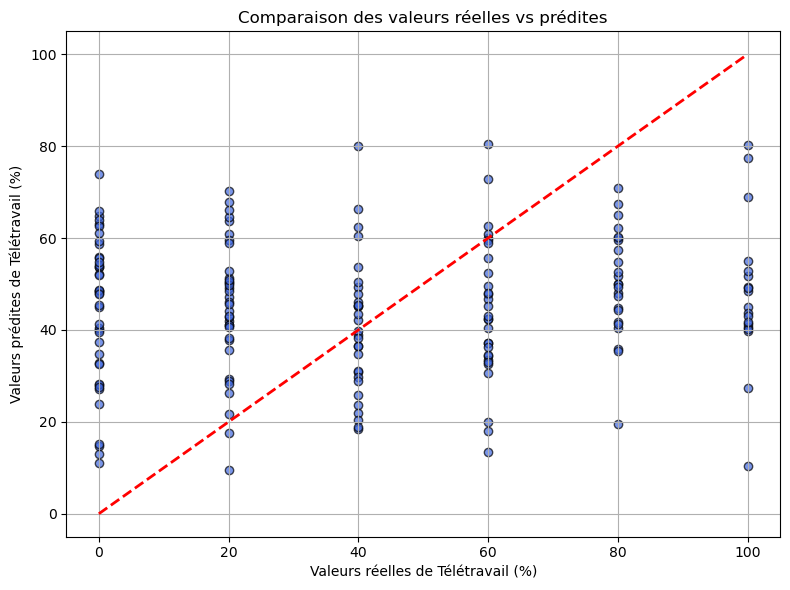

In [20]:


# Affichage des prédictions vs les vraies valeurs
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='royalblue', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valeurs réelles de Télétravail (%)")
plt.ylabel("Valeurs prédites de Télétravail (%)")
plt.title("Comparaison des valeurs réelles vs prédites")
plt.grid(True)
plt.tight_layout()
plt.show()
